In [2]:
%load_ext autoreload
%autoreload 2

# Imports

In [3]:
import os
from Bio import SeqIO, Entrez
from urllib.error import HTTPError
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
def load_seq_from_FASTA(filename, as_type="list"):
    fasta_records = SeqIO.parse(open(filename),'fasta')
    if as_type=="dict":
        sequences = {}
        for fasta_record in fasta_records:
            sequences[fasta_record.id] = str(fasta_record.seq)
        return sequences
    elif as_type=="list":
        sequences = []
        for fasta_record in fasta_records:
            sequences.append(str(fasta_record.seq))
        return sequences
    else:
        raise ValueError(f"Desired type {as_type} not supported.")


In [5]:
fn = os.path.join('..', 'data', 'sRNA', 'RNAInter', 'Download_data_RR.csv')
data = pd.read_csv(fn)
try:
    data = data.drop(columns=['Unnamed: 0'])
except:
    pass

# Minor pre-processing

## Filter species to only include E. coli

In [6]:
filt = ((data['Species1'] == 'Escherichia coli') | (data['Species1'] == 'Escherichia coli str. K-12 substr. MG1655')
        ) & ((data['Category1'] == 'sRNA') | (data['Category2'] == 'sRNA'))
# data[filt].reset_index().to_csv(fn)

In [7]:
data = data[filt].reset_index()

### Check for duplicates (mirrored interaction 1 and 2)

In [8]:
print('Number of duplicate entries:')
sum([len(data[(data['Interactor2.Symbol'] == i1) & (data['Interactor1.Symbol'] == i2)]) for i1, i2 in zip(data['Interactor1.Symbol'], data['Interactor2.Symbol'])])

Number of duplicate entries:


0

In [9]:
print('Number of unique raw IDs')
len(list(data['Raw_ID1'].unique()) + list(data['Raw_ID2'].unique()))

Number of unique raw IDs


308

<Axes: xlabel='score', ylabel='Count'>

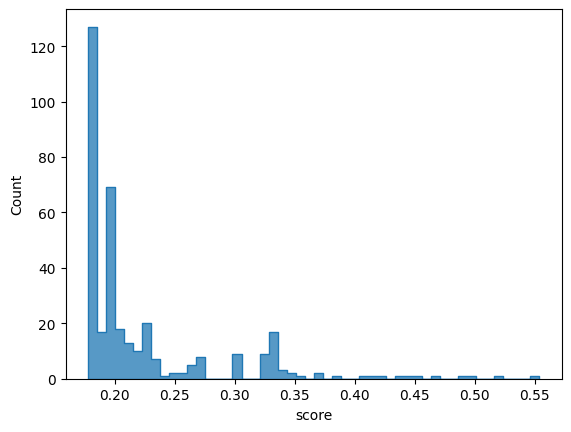

In [10]:
sns.histplot(data[filt], x='score', element='step', bins=50)

# Get sequences

In [125]:
Entrez.email = "olivia.gallup@gmail.com"  # Add your email address
Entrez.api_key = "8167226cf01abaa985a1c23d9b5283d22208"  # Add your NCBI API key


def get_fasta_from_genome(gene_id):
    try:
        handle = Entrez.efetch(db="gene", id=gene_id, rettype="fasta", retmode="xml")
        record = Entrez.read(handle)
        nuc_id = record[0]['Entrezgene_locus'][0]['Gene-commentary_accession'] + '.' + record[0]['Entrezgene_locus'][0]['Gene-commentary_version']

        dna_start = record[0]['Entrezgene_locus'][0]['Gene-commentary_seqs'][0]['Seq-loc_int']['Seq-interval']['Seq-interval_from']
        dna_end = record[0]['Entrezgene_locus'][0]['Gene-commentary_seqs'][0]['Seq-loc_int']['Seq-interval']['Seq-interval_to']

        search_handle = Entrez.efetch(db="nuccore", id=nuc_id, retmode="XML", rettype='fasta_cds_na', strand="complement", seq_start=int(dna_start), seq_stop=int(dna_end))
        # dna_sequence = SeqIO.read(search_handle, "fasta").seq
        r = search_handle.read()
        if r:
            dna_sequence = ''.join(r.split('>')[1].split('\n')[1:])
        else:
            dna_sequence = ''
        return dna_sequence
    except HTTPError:
        return ''


def get_fasta(gene_id):
    try:
        handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="fasta", retmode="text")
        fast = handle.read()
        seq = ''.join(fast.split('\n')[1:])
        if not seq:
            seq = get_fasta_from_genome(gene_id)
        return seq
    except HTTPError:
        seq = get_fasta_from_genome(gene_id)
        return seq


In [133]:
# if ('Sequence1' not in data.columns) or ('Sequence2' not in data.columns):
# data['Sequence1'] = data['Raw_ID1'].str.replace('NCBI:', '').apply(str).apply(get_fasta)
d = {k: get_fasta(k) for k in list(data['Raw_ID1'].str.replace('NCBI:', '').apply(str).unique()) + list(data['Raw_ID2'].str.replace('NCBI:', '').apply(str).unique())}

data['Sequence1'] = list(map(lambda x: d[x], data['Raw_ID1'].str.replace('NCBI:', '').apply(str)))
data['Sequence2'] = list(map(lambda x: d[x], data['Raw_ID2'].str.replace('NCBI:', '').apply(str)))
# data['Sequence1'] = data['Raw_ID1'].str.replace('NCBI:', '').apply(str).apply(get_fasta)

print(sum((data['Sequence1'] != '') & (data['Sequence2'] != '')))
data.to_csv(fn)


352


In [134]:
data[data['Sequence1'].isna()]

,level_0,index,RNAInterID,Interactor1.Symbol,Category1,Species1,Interactor2.Symbol,Category2,Species2,Raw_ID1,Raw_ID2,score,strong,weak,predict,Sequence1,Sequence2
